In [1]:
reset -sf

In [2]:
import sys
import os
import numpy as np 
import pandas as pd
from pathlib import Path

# univariate mlp example
from numpy import array

from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalMaxPooling1D, Input, add
from keras import layers
from keras.models import Model

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.externals import joblib 
import matplotlib.pyplot as plt

/home/administrador/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/administrador/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/administrador/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/administrador/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/administrador/anaconda3/lib/python3.6/importlib/_bo

In [3]:
PATH = Path("../../data/")

In [4]:
dfX_Train = np.load(PATH/'train_x.npy')
dfX_Val = np.load(PATH/'val_x.npy') 
dfX_Test = np.load(PATH/'test_x.npy')
dfY_Train = np.load(PATH/'train_y.npy')
dfY_Val = np.load(PATH/'val_y.npy')
dfY_Test = np.load(PATH/'test_y.npy')
print(dfX_Train.shape, dfY_Train.shape)
print(dfX_Val.shape, dfY_Val.shape)
print(dfX_Test.shape, dfY_Test.shape)
print(dfX_Train[0,:10])

(8126, 2500) (8126, 1250)
(1016, 2500) (1016, 1250)
(1016, 2500) (1016, 1250)
[1.0743 1.0802 1.1212 1.2092 1.35   1.5396 1.7664 2.0088 2.2473 2.4399]


In [5]:
history=None
freq = 125
ini = 0 #freq
dim = freq * 2
ecg = 1250

In [6]:
#Compute max, min
dfY_Train_sum = np.hstack((dfY_Train[:,ini:ini+dim].max(axis=1).reshape(-1,1), 
                           dfY_Train[:,ini:ini+dim].min(axis=1).reshape(-1,1), 
                           ))

dfY_Val_sum = np.hstack((dfY_Val[:,ini:ini+dim].max(axis=1).reshape(-1,1), 
                           dfY_Val[:,ini:ini+dim].min(axis=1).reshape(-1,1), 
                           ))

dfY_Test_sum = np.hstack((dfY_Test[:,ini:ini+dim].max(axis=1).reshape(-1,1), 
                           dfY_Test[:,ini:ini+dim].min(axis=1).reshape(-1,1), 
                           ))

print(dfY_Train_sum[0])
print(dfY_Val_sum[0])
print(dfY_Test_sum[0])

trainY_s = dfY_Train_sum
valY_s = dfY_Val_sum
testY_s = dfY_Test_sum

[134.32   69.749]
[167.73  69.31]
[135.93   70.531]


In [7]:
#Normalize Y
rng = (dfY_Train[:,ini:ini+dim].max(axis=1) - dfY_Train[:,ini:ini+dim].min(axis=1))
trainY_n = np.array([dfY_Train [:,i] - dfY_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Val[:,ini:ini+dim].max(axis=1) - dfY_Val[:,ini:ini+dim].min(axis=1))
valY_n = np.array([dfY_Val [:,i] - dfY_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Test[:,ini:ini+dim].max(axis=1) - dfY_Test[:,ini:ini+dim].min(axis=1))
testY_n = np.array([dfY_Test [:,i] - dfY_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

trainY_n = trainY_n.T
valY_n = valY_n.T
testY_n = testY_n.T 

In [8]:
#Normalize X
rng = (dfX_Train[:,ini:ini+dim].max(axis=1) - dfX_Train[:,ini:ini+dim].min(axis=1))
trainX_0_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Train[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Train[:,ecg+ini:ini+ecg+dim].min(axis=1))
trainX_1_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Val[:,ini:ini+dim].max(axis=1) - dfX_Val[:,ini:ini+dim].min(axis=1))
valX_0_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Val[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Val[:,ecg+ini:ini+ecg+dim].min(axis=1))
valX_1_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Test[:,ini:ini+dim].max(axis=1) - dfX_Test[:,ini:ini+dim].min(axis=1))
testX_0_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Test[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Test[:,ecg+ini:ini+ecg+dim].min(axis=1))
testX_1_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

trainX_0_n = trainX_0_n.T
trainX_1_n = trainX_1_n.T
valX_0_n = valX_0_n.T
valX_1_n = valX_1_n.T
testX_0_n = testX_0_n.T 
testX_1_n = testX_1_n.T

print(trainX_0_n.shape,trainX_1_n.shape)
print(valX_0_n.shape,valX_1_n.shape)
print(testX_0_n.shape,testX_1_n.shape)

(8126, 250) (8126, 250)
(1016, 250) (1016, 250)
(1016, 250) (1016, 250)


In [9]:
trainX_n = np.stack((trainX_0_n, trainX_1_n), axis=2)
valX_n = np.stack((valX_0_n,valX_1_n), axis=2)
testX_n = np.stack((testX_0_n, testX_1_n), axis=2)

print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [10]:
#Load

In [11]:
from keras.models import model_from_json

# load json and create model
json_file = open('conv1d_hm.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_hm = model_from_json(loaded_model_json)
model_hm.load_weights("conv1d_hm.h5")
print("Loaded model from disk")

Loaded model from disk


In [12]:
# load json and create model
json_file = open('conv1d.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
model.load_weights("conv1d.h5")
print("Loaded model from disk")

Loaded model from disk


In [13]:
#Evaluation

In [14]:
y_pred = []
for ix in range(testX_n.shape[0]):
    y_pred.append(model.predict([np.expand_dims(testX_n[ix,:].reshape(250,2),0)]))

In [15]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

y_pred = np.array(y_pred).reshape(-1,250)
print(y_pred.shape, testY_n.shape)
print("Test error analysis:")
print("Explained variance score:", explained_variance_score(testY_n, y_pred))
print("MAE error:", mean_absolute_error(testY_n, y_pred))
print("MSE error:", mean_squared_error(testY_n, y_pred))
print("R2 score:", r2_score(testY_n, y_pred))

(1016, 250) (1016, 250)
Test error analysis:
Explained variance score: 0.7369468164276015
MAE error: 0.11385018394813488
MSE error: 0.02610743472947844
R2 score: 0.7339271174636147


/home/administrador/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [16]:
#Predict [max, min]

In [17]:
y_pred_stats = []
for ix in range(testX_n.shape[0]):
    y_pred_stats.append(model_hm.predict([np.expand_dims(testX_n[ix,:].reshape(250,2),0)]))

In [18]:
y_pred_stats = np.array(y_pred_stats).reshape(-1,2)
print(y_pred_stats.shape, testY_s.shape)
print("Test error analysis:")
print("Explained variance score:", explained_variance_score(testY_s, y_pred_stats))
print("MAE error:", mean_absolute_error(testY_s, y_pred_stats))
print("MSE error:", mean_squared_error(testY_s, y_pred_stats))
print("R2 score:", r2_score(testY_s, y_pred_stats))

(1016, 2) (1016, 2)
Test error analysis:
Explained variance score: 0.05330029854554491
MAE error: 12.573775065294384
MSE error: 297.6106609911296
R2 score: 0.003930234379871833


In [19]:
#Combined

In [20]:
print(y_pred_stats.shape)
print(y_pred.shape)
y_pred_combined = (y_pred * (y_pred_stats[:,0] - y_pred_stats[:,1]).reshape(-1,1)) + y_pred_stats[:,1].reshape(-1,1)
print(y_pred_combined.shape)

(1016, 2)
(1016, 250)
(1016, 250)


In [21]:
testY = dfY_Test[:,ini:ini+dim]
print(y_pred.shape, testY.shape)
print("Test error analysis:")
print("Explained variance score:", explained_variance_score(testY, y_pred_combined))
print("MAE error:", mean_absolute_error(testY, y_pred_combined))
print("MSE error:", mean_squared_error(testY, y_pred_combined))
print("R2 score:", r2_score(testY, y_pred_combined))

(1016, 250) (1016, 250)
Test error analysis:
Explained variance score: 0.50846569259504
MAE error: 13.176705312532443
MSE error: 323.943152345994
R2 score: 0.4850187281262115


In [ ]:
#Save results

In [27]:
pd.DataFrame(y_pred_combined).to_csv("bp_predicted.csv")
pd.DataFrame(testY).to_csv("bp_real.csv")

In [22]:
# Visualize

In [23]:
ix = 12
mx, mn = model_hm.predict([np.expand_dims(testX_n[ix,:].reshape(250,2),0)])[0]
print("Pred: max -",mx, "min -", mn)
print("Real: max -",dfY_Test[ix,ini:ini+dim].max(), "min -", dfY_Test[ix,ini:ini+dim].min())

norm_ix = model.predict(np.expand_dims(testX_n[ix,:], axis=0))
denorm_ix = (norm_ix * (mx-mn)) + mn

Pred: max - 127.151115 min - 61.811287
Real: max - 124.94 min - 56.36600000000001


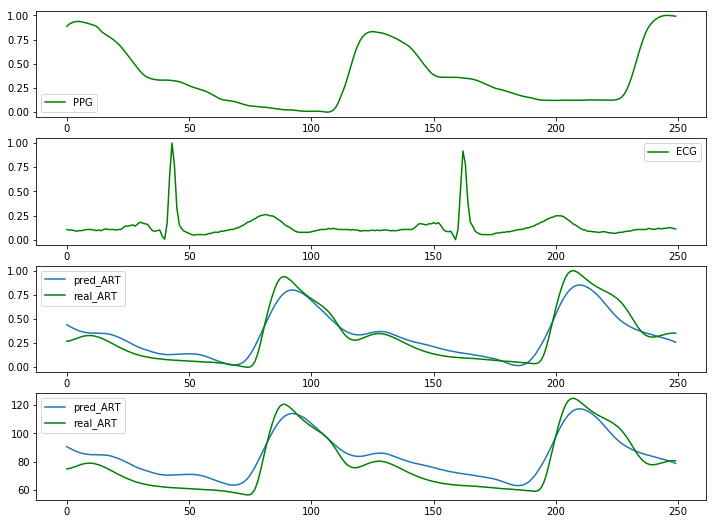

In [24]:
plt.figure(figsize=(12,9))
ax = plt.subplot(4,1,1)
ax.plot(testX_0_n[ix,:].reshape(1,-1).T, c="g", label="PPG")
ax.legend()

ax = plt.subplot(4,1,2)
ax.plot(testX_1_n[ix,:].reshape(1,-1).T, c="g", label="ECG")
plt.legend()


ax = plt.subplot(4,1,3)
ax.plot(norm_ix.T, label="pred_ART")
ax.plot(testY_n[ix,:].reshape(1,-1).T, c="g", label="real_ART")
ax.legend()

ax = plt.subplot(4,1,4)
ax.plot(denorm_ix.T, label="pred_ART")
ax.plot(dfY_Test[ix,ini:ini+dim].reshape(1,-1).T, c="g", label="real_ART")
ax.legend()

plt.show()